In [1]:
import pandas as pd
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

//home/data1/Jindc/shawb/anaconda3/envs/torch19/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the dataset which is in csv format
location1=pd.read_csv('Location1.csv')#2017-1-02-0:00  --  2021-12-31-23:00
location2=pd.read_csv('Location2.csv')
location3=pd.read_csv('Location3.csv')
test_location4=pd.read_csv('Location4.csv')

In [3]:
def create_lag_features_3d(data, target_col='Power', input_steps=24, forecast_steps=1, 
                           feature_order=None):
    """
    为风功率预测构造3D滞后特征 (B, T, C)
    
    参数:
        data: DataFrame, 必须包含时间索引
        target_col: str, 目标变量列名
        input_steps: int, 输入历史时间步长T
        forecast_steps: int, 预测未来步数
        feature_order: list, 特征顺序（如['wind_speed', 'temperature']）
    
    返回:
        X: numpy.ndarray, 形状 (样本数, input_steps, 特征数)
        y: numpy.ndarray, 形状 (样本数, forecast_steps)
    """
    df = data.sort_index().copy()
    
    # 自动识别特征列（排除目标列和非数值列）
    if feature_order is None:
        feature_order = [col for col in df.columns 
                         if col not in [target_col, 'Time', 'Location'] 
                         and pd.api.types.is_numeric_dtype(df[col])]
    
    print(f"原始数据形状: {df.shape}")
    print(f"目标变量: {target_col}")
    print(f"输入时间步: {input_steps}")
    print(f"预测步数: {forecast_steps}")
    print(f"特征列表: {feature_order} (共{len(feature_order)}个特征)")
    
    # 1. 构造3D输入特征 (B, T, C)
    n_features = len(feature_order)
    n_samples = len(df) - input_steps - forecast_steps + 1
    
    X = np.zeros((n_samples, input_steps, n_features))
    y = np.zeros((n_samples, forecast_steps))
    
    for i in range(n_samples):
        # 对每个样本：提取过去input_steps小时、所有特征的值
        for j, feature in enumerate(feature_order):
            X[i, :, j] = df[feature].iloc[i:i+input_steps].values
        
        # 提取未来forecast_steps小时的目标值
        y[i, :] = df[target_col].iloc[i+input_steps : i+input_steps+forecast_steps].values
    
    print(f"构造完成:")
    print(f"  X形状: {X.shape} (B: {X.shape[0]}, T: {X.shape[1]}, C: {X.shape[2]})")
    print(f"  y形状: {y.shape}")
    
    # 验证最后一个样本
    print(f"\n验证样本0:")
    print(f"  X[0] 形状: {X[0].shape}")
    print(f"  y[0] 形状: {y[0].shape}")
    print(f"  X[0, :, 0] (第一个特征的历史序列): {X[0, :, 0][:5]} ...")
    
    return X, y

In [4]:
from torch.utils.data import Dataset, DataLoader
class WindPowerDataset(Dataset):
    """风功率3D数据集"""
    def __init__(self, X, y):
        """
        X: numpy array, 形状 (样本数, 时间步, 特征数)
        y: numpy array, 形状 (样本数, 预测步数)
        """
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # 返回单个样本 (X, y)
        #print(self.y.shape)
        return self.X[idx], self.y[idx]

In [5]:
trainx,trainy = create_lag_features_3d(location1,'Power',6,12)
testx,testy = create_lag_features_3d(location2.iloc[:2400],'Power',6,12)

原始数据形状: (43800, 10)
目标变量: Power
输入时间步: 6
预测步数: 12
特征列表: ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'windspeed_10m', 'windspeed_100m', 'winddirection_10m', 'winddirection_100m', 'windgusts_10m'] (共8个特征)
构造完成:
  X形状: (43783, 6, 8) (B: 43783, T: 6, C: 8)
  y形状: (43783, 12)

验证样本0:
  X[0] 形状: (6, 8)
  y[0] 形状: (12,)
  X[0, :, 0] (第一个特征的历史序列): [28.5 28.4 26.8 27.4 27.3] ...
原始数据形状: (2400, 10)
目标变量: Power
输入时间步: 6
预测步数: 12
特征列表: ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'windspeed_10m', 'windspeed_100m', 'winddirection_10m', 'winddirection_100m', 'windgusts_10m'] (共8个特征)
构造完成:
  X形状: (2383, 6, 8) (B: 2383, T: 6, C: 8)
  y形状: (2383, 12)

验证样本0:
  X[0] 形状: (6, 8)
  y[0] 形状: (12,)
  X[0, :, 0] (第一个特征的历史序列): [14.5 14.5 14.7 14.7 14.8] ...


In [6]:
class LSTM(nn.Module):
    def __init__(self, 
                 input_channels: int,  # 输入通道数c
                 hidden_size: int = 64,
                 num_layers: int = 1):  # 核心参数：控制LSTMCell的层数
        super().__init__()
        self.input_channels = input_channels
        self.hidden_size = hidden_size
        self.num_layers = num_layers  # 记录层数
        
        # 按层数创建LSTMCell列表（每层一个独立的LSTMCell）
        self.lstm_cells = nn.ModuleList()
        for layer in range(num_layers):
            # 第一层输入维度=input_channels，后续层输入维度=hidden_size
            in_dim = input_channels if layer == 0 else hidden_size
            self.lstm_cells.append(nn.LSTMCell(in_dim, hidden_size))
        
        # 输出映射层：将最后一层的隐藏状态映射到输出维度
        self.out_proj = nn.Linear(hidden_size, input_channels)
        self.last = nn.Linear(input_channels, 1)

    def forward(self, 
                x: torch.Tensor, 
                output_time_steps: int):  # 控制输出的时间步数量
        """
        多层LSTMCell循环实现：
        1. 编码阶段：多层循环处理输入序列
        2. 生成阶段：多层循环生成指定数量的输出时间步
        :param x: 输入 (b, t, c)
        :param output_time_steps: 要输出的时间步数量
        :return: 输出 (b, output_time_steps, c)
        """
        batch_size, input_time_steps, _ = x.shape
        device = x.device

        # ------------------- 第一步：多层编码（处理输入序列） -------------------
        # 初始化所有层的隐藏状态h和细胞状态c（每层都有自己的h/c）
        h_list = [torch.zeros(batch_size, self.hidden_size, device=device) for _ in range(self.num_layers)]
        c_list = [torch.zeros(batch_size, self.hidden_size, device=device) for _ in range(self.num_layers)]

        # 循环处理输入的每一个时间步（外层：输入时间步循环）
        for t in range(input_time_steps):
            x_t = x[:, t, :]  # 当前时间步输入 (b, c)
            
            # 逐层处理（内层：层数循环）
            for layer in range(self.num_layers):
                # 第一层输入是原始x_t，后续层输入是前一层的h
                layer_input = x_t if layer == 0 else h_list[layer-1]
                # 更新当前层的h和c
                h_list[layer], c_list[layer] = self.lstm_cells[layer](layer_input, (h_list[layer], c_list[layer]))

        # ------------------- 第二步：多层生成（指定输出时间步） -------------------
        generated_outputs = []
        # 生成的初始输入（用0向量，也可改用最后一层的输出）
        gen_input = torch.zeros(batch_size, self.input_channels, device=device)
        
        # 循环生成指定数量的输出时间步（外层：输出时间步循环）
        for _ in range(output_time_steps):
            # 逐层处理生成（内层：层数循环）
            for layer in range(self.num_layers):
                # 第一层输入是gen_input，后续层输入是前一层的h
                layer_input = gen_input if layer == 0 else h_list[layer-1]
                # 更新当前层的h和c
                h_list[layer], c_list[layer] = self.lstm_cells[layer](layer_input, (h_list[layer], c_list[layer]))
            
            # 取最后一层的h映射为输出
            gen_output = self.out_proj(h_list[-1])
            
            # 自回归：当前输出作为下一步的输入
            gen_input = gen_output
            gen_output = self.last(gen_output)
            generated_outputs.append(gen_output)

        # 拼接生成的输出，形状 (b, output_time_steps, c)
        outputs = torch.stack(generated_outputs, dim=1)
        return outputs.squeeze(2)

In [7]:
train_dataset = WindPowerDataset(trainx, trainy)
test_dataset = WindPowerDataset(testx, testy)
train_loader = DataLoader(
    train_dataset, 
    batch_size=32,      # 每批32个样本
    shuffle=True,       # 打乱顺序（训练集必须）
    #num_workers=4,      # 并行加载数据
    #pin_memory=True     # 加速GPU传输
    drop_last=True
)
#train_iter = iter(train_loader)

# 2. 获取第一个批次
#X_batch, y_batch = next(train_iter)
#print(f"y_batch 形状: {y_batch.shape}")

test_loader = DataLoader(
    test_dataset,
    batch_size=24,
    shuffle=False,      # 测试集不打乱
    #num_workers=4
    drop_last=True
)
device = torch.device('cuda:2')
lstm_model = LSTM(8,128,3).to(device)

In [107]:
epoch = 30
mseloss = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
for i in range(epoch):
    total_loss=0
    for idx, (x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        if y.shape[1] !=12:
             print(idx)
        pred = lstm_model(x,12)
        loss = mseloss(pred,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (i + 1) % 2 == 0:
            avg_loss = total_loss / len(train_loader)
            print(f'Epoch [{i+1}/{epoch}], Loss: {avg_loss:.4f}')
chk = torch.save(lstm_model.state_dict(), 'lstm_weight.pth')

Epoch [2/30], Loss: 0.0445
Epoch [4/30], Loss: 0.0430
Epoch [6/30], Loss: 0.0424
Epoch [8/30], Loss: 0.0418
Epoch [10/30], Loss: 0.0412
Epoch [12/30], Loss: 0.0407
Epoch [14/30], Loss: 0.0399
Epoch [16/30], Loss: 0.0393
Epoch [18/30], Loss: 0.0390
Epoch [20/30], Loss: 0.0384
Epoch [22/30], Loss: 0.0377
Epoch [24/30], Loss: 0.0372
Epoch [26/30], Loss: 0.0362
Epoch [28/30], Loss: 0.0356
Epoch [30/30], Loss: 0.0348


In [8]:
testmodel = LSTM(8,128,3)
testmodel.load_state_dict(torch.load('lstm_weight.pth'))
testmodel = testmodel.to(device)
allx = np.zeros([2400,6,8])
ally = np.zeros([2400,12])
allp = np.zeros([2400,12])
i = 0  # 记录当前已填充的位置
for idx,(test_in,test_label) in enumerate(test_loader):
    test_in = test_in.to(device)
    test_pred = testmodel(test_in,12)
    allx[i:i+24]= test_in.cpu().numpy()
    ally[i:i+24]= test_label.cpu().numpy()
    allp[i:i+24] = test_pred.detach().cpu().numpy()
    i+=+24
print(allp.shape)

(2400, 12)


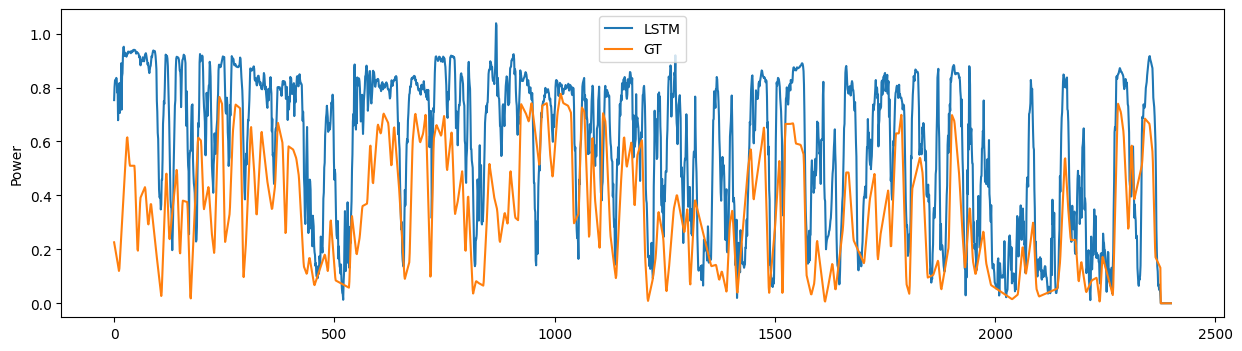

In [13]:
plt.figure(figsize=(15,4))
plt.plot(allp[:,0],label='LSTM')
plt.plot(ally[:,0],label='GT')
plt.ylabel('Power')
plt.legend()